### Author: Kubam Ivo
### Date: 7/21/2020

# Classification of Credit card fraudulent transactions

In [2]:
# setting up
import logging

from matplotlib import pyplot as plt 
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [3]:
# setting up workspace and experiment

ws = Workspace.from_config()

experiment_name = 'auto-classification-card-remote'

experiment = Experiment(ws, experiment_name)

output = {}
output['subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T


,
subscription ID,a1839f8e-ad8f-4825-ab97-e9628255f2bb
Workspace,ml_practice
Resource Group,azureml
Location,westeurope
Experiment Name,auto-classification-card-remote


In [14]:
# Attaching existimg AmlCompute

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cpu_cluster_name = 'mlcompute'
compute_target = ComputeTarget(ws, cpu_cluster_name)

In [11]:
# Loading Data
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
Dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = Dataset.random_split(percentage=0.8, seed=223)
label_column_name = 'Class'

In [17]:
# Instantiate and automl config object

automl_settings = {
    "n_cross_validation": 3,
    "primary_metric": 'average_precision_score_weighted',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2,
    "experiment_timeout_hours": 0.25,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                debug_log='automl_errors.log',
                compute_target = compute_target, # change to local to do a local run
                training_data= training_data,
                label_column_name =  label_column_name,
                **automl_settings)

In [18]:
remote_run = experiment.submit(automl_config, show_output = False)

WARNING - Received unrecognized parameter n_cross_validation


Running on remote or ADB.


In [20]:
# Retrieving best model
best_run, fitted_model = remote_run.get_output()
fitted_model

WARNING - Received unrecognized parameter n_cross_validation
WARNING - Received unrecognized parameter n_cross_validation


PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=Non...66666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]))]},
               y_transformer={}, y_transformer_name='LabelEncoder')

In [21]:
# convert the test data to pandas dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name]).to_pandas_dataframe()

In [22]:
#predicting labels 
y_pred = fitted_model.predict(X_test_df)
y_pred


array([False, False, False, ..., False, False, False])

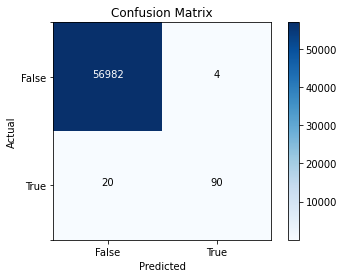

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()